In [57]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import random
import scanpy as sc
import os
import networkx as nx
from scipy import interpolate
import gc
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.colors as mcolors
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

ModuleNotFoundError: No module named 'gget'

In [2]:
torch.cuda.empty_cache()
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)
print('loaded!')

loaded!


In [3]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)

# get the yamanaka factors
yamanaka_genes = [
    "POU5F1", # OCT4
    "SOX2",
    "KLF4",
    "MYC"
]

yam_df = token_df[token_df['gene_name'].isin(yamanaka_genes)]
yamanaka_tokens = yam_df['token_id'].to_list()
yam_df

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
7301,ENSG00000136826,7301,KLF4,3.854239,15.0,protein_coding,9,107484851.0,107490482.0,True
7352,ENSG00000136997,7352,MYC,3.453890,21.0,protein_coding,8,127735433.0,127742951.0,True
14712,ENSG00000181449,14712,SOX2,6.858042,4.0,protein_coding,3,181711924.0,181714436.0,True
17679,ENSG00000204531,17679,POU5F1,3.540753,21.0,protein_coding,6,31164336.0,31180731.0,True


# load the data

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/xing_2020_reprogramming_data/fib_reprogramming.dataset"

sample_size = 10
df = gtu.load_data_as_dataframe(fpath, num_cells=sample_size)
df.head()

,input_ids,Cell ID,Time-point,n_counts,length
0,"[5592, 20053, 16725, 5368, 2183, 5401, 10600, ...",AAACCTGAGGAGTTGC-1,D0,19091,2048
1,"[20053, 3481, 17126, 7923, 2183, 11143, 13399,...",AAACCTGAGTACTTGC-1,D0,23435,2048
2,"[1720, 2183, 17126, 12172, 4686, 4415, 7923, 2...",AAACCTGAGTATGACA-1,D0,30118,2048
3,"[7923, 14947, 2183, 17126, 20053, 5298, 3219, ...",AAACCTGCACCATGTA-1,D0,20995,2048
4,"[20053, 16725, 11143, 2183, 5368, 7923, 13698,...",AAACCTGCACCTTGTC-1,D0,17087,2048


# Perturb

In [5]:
def add_perturbations_to_cell(cell_tokens, perturbation_tokens):
    """
    Modifies a list of cell tokens by adding perturbation tokens and padding.

    Args:
        cell_tokens (list): A list of integers representing gene tokens.
        perturbation_tokens (list): A list of integers representing perturbation tokens.

    Returns:
        list: A new list of tokens with perturbations added, existing perturbations removed,
             and truncated/padded to the original length.
    """

    original_length = len(cell_tokens)

    # Remove existing perturbation tokens from the cell
    cell_tokens = [token for token in cell_tokens if token not in perturbation_tokens]

    # Add perturbations, then slice or pad to match original length
    final_tokens = (perturbation_tokens + cell_tokens)[:original_length]  # Slice if too long
    final_tokens += [0] * (original_length - len(final_tokens))            # Pad if too short

    return final_tokens

# test
test_cell = df.head(1)['input_ids'].values[0]
perturbed = add_perturbations_to_cell(test_cell, yamanaka_tokens)

print(test_cell[:10])
print(perturbed[:10])

[ 5592 20053 16725  5368  2183  5401 10600  1281 14659  5744]
[7301, 7352, 14712, 17679, 5592, 20053, 16725, 5368, 2183, 5401]


# structure the data

In [6]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/xing_2020_reprogramming_data/fib_reprogramming.dataset"

df = gtu.load_data_as_dataframe(fpath, num_cells=None)
print(f"{df.shape=}")
print()
print(df['Time-point'].value_counts())
print()
df.head()

df.shape=(32138, 5)

Time-point
D0              7079
D12             7013
D16_negative    6781
D2              4988
D8              3619
D16_positive    2658
Name: count, dtype: int64



,input_ids,Cell ID,Time-point,n_counts,length
0,"[5592, 20053, 16725, 5368, 2183, 5401, 10600, ...",AAACCTGAGGAGTTGC-1,D0,19091,2048
1,"[20053, 3481, 17126, 7923, 2183, 11143, 13399,...",AAACCTGAGTACTTGC-1,D0,23435,2048
2,"[1720, 2183, 17126, 12172, 4686, 4415, 7923, 2...",AAACCTGAGTATGACA-1,D0,30118,2048
3,"[7923, 14947, 2183, 17126, 20053, 5298, 3219, ...",AAACCTGCACCATGTA-1,D0,20995,2048
4,"[20053, 16725, 11143, 2183, 5368, 7923, 13698,...",AAACCTGCACCTTGTC-1,D0,17087,2048


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


embs.shape=(5000, 512)


/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [7025, 15990, 6415, 4350, 11194]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


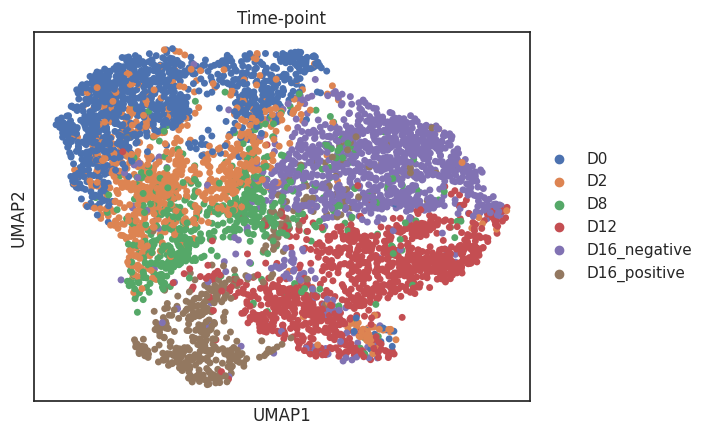

In [7]:
torch.cuda.empty_cache()
sample_size = 5000
pdf = df.sample(sample_size)
data = Dataset.from_pandas(pdf)
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = pdf.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["Time-point"],
    ncols=1,
    size=100,
    color_map='tab20',
)

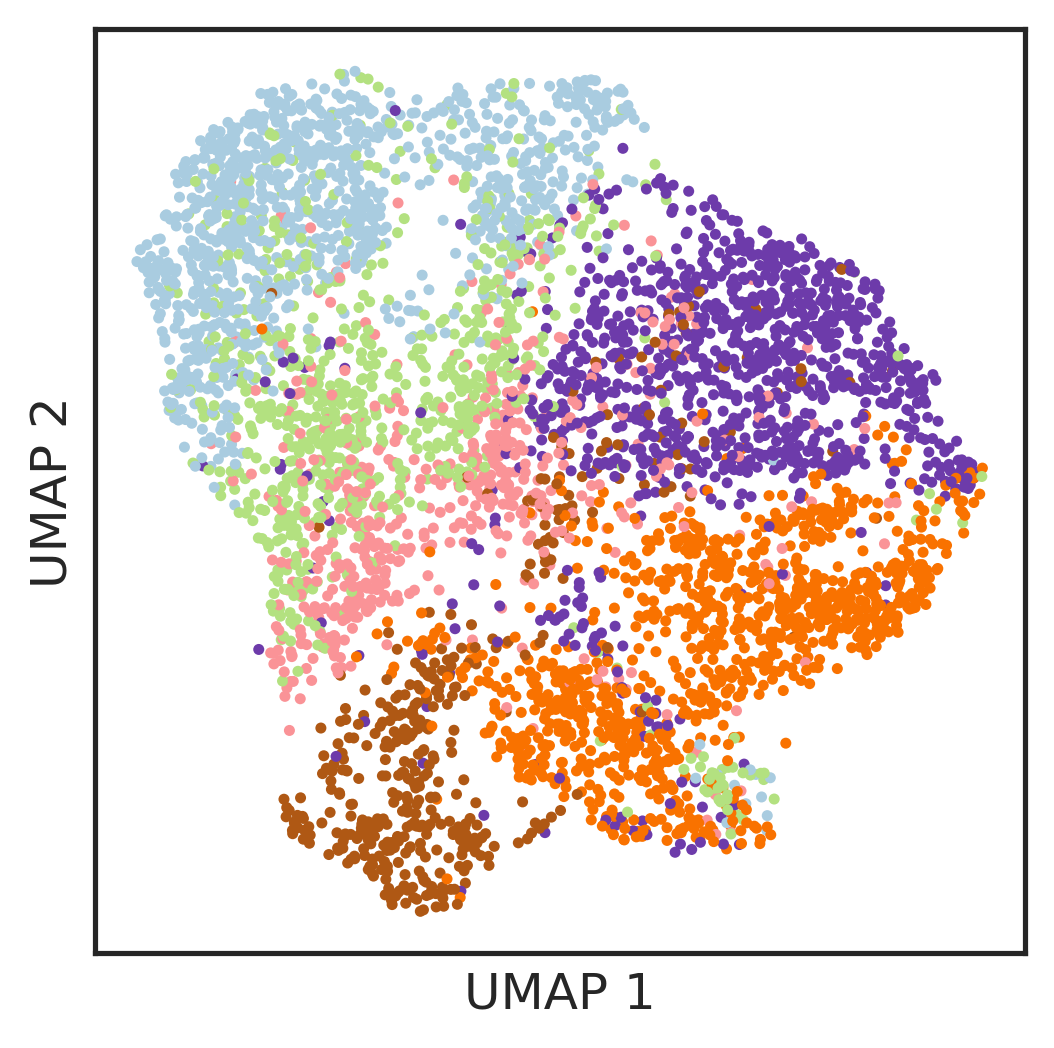

In [8]:
# recapitulate the paper figure

color_stage_map = {
    "D0": "#A9CCE0",
    "D2": "#B3E180",
    "D8": "#FA9397",
    "D12": "#F97200",
    "D16_negative": "#6D3BAA",
    "D16_positive": "#AF5814"
}

adata.obs['color'] = adata.obs["Time-point"].map(color_stage_map)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=adata.obs,
                x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                c=adata.obs['color'].values,
                ec='none',
                s=7,
               )

plt.yticks([])
plt.xticks([])

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

plt.gca().set_aspect('auto')

# sns.move_legend(plt.gca(),
#                 loc='upper right',
#                 bbox_to_anchor=(1.4, 1),
#                )

In [9]:
# break

# in silico reprogramming

In [10]:
# randomly sample fom FB profiles from the first time-point
sample_size = 100
fib = df[df['Time-point'] == "D0"].copy()
ipsc = df[df['Time-point'] == "D16_positive"].copy()

print(f"{fib.shape=}")
print(f"{ipsc.shape=}")

# downsample
fib = fib.sample(sample_size)
ipsc = ipsc.sample(sample_size)

# perturb the fib data
fib_pert = fib.copy()
fib_pert['input_ids'] = fib_pert['input_ids'].apply(lambda x: add_perturbations_to_cell(x, yamanaka_tokens))


# add a new metatdata column
fib_pert['cell_type'] = 'Reprogrammed'
fib['cell_type'] = 'Fibroblast'
ipsc['cell_type'] = 'iPSC'

# create the combined dataframe and hugging face data
pdf = pd.concat([fib, fib_pert, ipsc])
print(f"{pdf.shape=}")

data = Dataset.from_pandas(pdf)
pdf.head()

fib.shape=(7079, 5)
ipsc.shape=(2658, 5)
pdf.shape=(300, 6)


,input_ids,Cell ID,Time-point,n_counts,length,cell_type
2343,"[20053, 5368, 2042, 11411, 5298, 3481, 14947, ...",CCCAGTTGTTTGTTTC-1,D0,17590,2048,Fibroblast
861,"[20053, 7923, 2183, 14659, 14947, 1984, 5716, ...",AGACGTTGTTACTGAC-1,D0,13146,2048,Fibroblast
6101,"[20053, 1720, 11143, 2183, 14659, 5368, 8454, ...",TCGGGACCATCAGTAC-1,D0,21903,2048,Fibroblast
4667,"[20053, 3481, 13771, 7923, 11293, 11143, 2183,...",GGATGTTCAACACCTA-1,D0,15509,2048,Fibroblast
4986,"[20053, 3481, 14659, 7923, 11143, 2183, 16162,...",GTAACGTGTCACCCAG-1,D0,15543,2048,Fibroblast


In [11]:
torch.cuda.empty_cache()

# gene embedding extraction
embs = gtu.extract_embedding_in_mem(model, data, emb_mode='gene', layer_to_quant=-1)
print(f"{embs.shape=}")

100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


embs.shape=(300, 2048, 512)


In [12]:
# now we have to structure the data for analysis
res = []

features = [f"g{i}" for i in range(512)]


for i, (pdf_row, emb_matrix) in enumerate(zip(pdf.iterrows(), embs)):
    _, metadata = pdf_row
    
    gene_id = metadata['input_ids']
    cell_id = metadata['Cell ID']
    time_point = metadata['Time-point']
    cell_type = metadata['cell_type']
    
    exp_df = pd.DataFrame(emb_matrix, 
                          columns=features, 
                         )
    
    # handle unpadded inputs
    if len(gene_id) < 2048:
        pad = ([0] * (2048 - len(gene_id)))
        gene_id = list(gene_id) + list(pad)
        
    exp_df['token_id'] = gene_id
    exp_df['cell_id'] = cell_id
    exp_df['time_point'] = time_point
    exp_df['cell_type'] = cell_type

    res.append(exp_df)

res = pd.concat(res)
print(f"{res.shape=}")

# map the gene_names
res = pd.merge(res, token_df,
               how='left',
               left_on='token_id',
               right_on='token_id',
              )

metadata_columns = res.loc[:, ~res.columns.isin(features)].columns.to_list()

res.head()

res.shape=(614400, 516)


,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,cell_type,gene_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,-0.561768,-0.237390,1.020778,-0.102550,-1.054629,0.576650,0.266751,0.072622,0.885792,0.716308,...,Fibroblast,ENSG00000235162,C12orf75,3.510553,9.0,protein_coding,12,105235289.0,105396097.0,False
1,-0.593566,0.239495,1.322877,-0.109304,0.207778,0.407718,-0.371732,0.454414,0.751738,0.480086,...,Fibroblast,ENSG00000123416,TUBA1B,9.099507,15.0,protein_coding,12,49127781.0,49131397.0,False
2,0.036845,-0.142890,0.989452,-0.304318,-0.146218,0.462342,0.018363,-0.039914,0.807826,1.054709,...,Fibroblast,ENSG00000095752,IL11,1.325586,7.0,protein_coding,19,55364381.0,55370463.0,False
3,-0.149770,0.085962,1.052543,-0.084854,-0.942844,0.465984,-0.156791,-0.053061,0.985483,0.991396,...,Fibroblast,ENSG00000164932,CTHRC1,2.592488,13.0,protein_coding,8,103371537.0,103382989.0,False
4,0.638480,0.347580,0.990833,-0.227606,0.347375,0.636655,-0.117852,0.201433,1.002464,0.350592,...,Fibroblast,ENSG00000122786,CALD1,8.075359,20.0,protein_coding,7,134744251.0,134970729.0,False


In [13]:
res.loc[:, ~res.columns.isin(features)].head()

,token_id,cell_id,time_point,cell_type,gene_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,20053,CCCAGTTGTTTGTTTC-1,D0,Fibroblast,ENSG00000235162,C12orf75,3.510553,9.0,protein_coding,12,105235289.0,105396097.0,False
1,5368,CCCAGTTGTTTGTTTC-1,D0,Fibroblast,ENSG00000123416,TUBA1B,9.099507,15.0,protein_coding,12,49127781.0,49131397.0,False
2,2042,CCCAGTTGTTTGTTTC-1,D0,Fibroblast,ENSG00000095752,IL11,1.325586,7.0,protein_coding,19,55364381.0,55370463.0,False
3,11411,CCCAGTTGTTTGTTTC-1,D0,Fibroblast,ENSG00000164932,CTHRC1,2.592488,13.0,protein_coding,8,103371537.0,103382989.0,False
4,5298,CCCAGTTGTTTGTTTC-1,D0,Fibroblast,ENSG00000122786,CALD1,8.075359,20.0,protein_coding,7,134744251.0,134970729.0,False


In [50]:
# some analysis
pdf = res.copy()

# keep only genes expressed in all three conditions
pdf['cell_type_count'] = pdf.groupby('gene_name')['cell_type'].transform('nunique')
pdf = pdf[pdf['cell_type_count'] == 3.0]

print(f"{pdf['gene_name'].nunique()=}")

pdf.head()

pdf['gene_name'].nunique()=7206


,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,gene_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf,cell_type_count
0,-0.561768,-0.237390,1.020778,-0.102550,-1.054629,0.576650,0.266751,0.072622,0.885792,0.716308,...,ENSG00000235162,C12orf75,3.510553,9.0,protein_coding,12,105235289.0,105396097.0,False,3.0
1,-0.593566,0.239495,1.322877,-0.109304,0.207778,0.407718,-0.371732,0.454414,0.751738,0.480086,...,ENSG00000123416,TUBA1B,9.099507,15.0,protein_coding,12,49127781.0,49131397.0,False,3.0
2,0.036845,-0.142890,0.989452,-0.304318,-0.146218,0.462342,0.018363,-0.039914,0.807826,1.054709,...,ENSG00000095752,IL11,1.325586,7.0,protein_coding,19,55364381.0,55370463.0,False,3.0
3,-0.149770,0.085962,1.052543,-0.084854,-0.942844,0.465984,-0.156791,-0.053061,0.985483,0.991396,...,ENSG00000164932,CTHRC1,2.592488,13.0,protein_coding,8,103371537.0,103382989.0,False,3.0
4,0.638480,0.347580,0.990833,-0.227606,0.347375,0.636655,-0.117852,0.201433,1.002464,0.350592,...,ENSG00000122786,CALD1,8.075359,20.0,protein_coding,7,134744251.0,134970729.0,False,3.0


In [51]:
# now average the embeddings by cell type for each gene
gx = pdf.groupby(['gene_name', 'cell_type'])[features].mean().reset_index()

result = []
# compute distances 
for gene_name, group in gx.groupby('gene_name'):

    dist_df = pd.DataFrame(cosine_distances(group[features]), 
                           index=group['cell_type'].values, 
                           columns=group['cell_type'].values)
    
    row = {
        'gene_name' : gene_name,
        'Fibroblast_to_Reprogrammed' : dist_df.loc['Fibroblast', 'Reprogrammed'],
        'Fibroblast_to_iPSC' : dist_df.loc['Fibroblast', 'iPSC'],
        'Reprogrammed_to_iPSC' : dist_df.loc['Reprogrammed', 'iPSC'],
    }
    result.append(row)
        
result = pd.DataFrame(result)
print(f"{result.shape=}")
result.head()

result.shape=(7206, 4)


,gene_name,Fibroblast_to_Reprogrammed,Fibroblast_to_iPSC,Reprogrammed_to_iPSC
0,A1BG,0.000836,0.027104,0.027029
1,A4GALT,0.022041,0.049362,0.034280
2,AAAS,0.000903,0.016004,0.016187
3,AACS,0.016001,0.067159,0.050630
4,AAGAB,0.008577,0.018657,0.017559


In [52]:
result['towards_ipsc'] = result['Reprogrammed_to_iPSC'] < result['Fibroblast_to_iPSC']

result['towards_ipsc'].value_counts()

towards_ipsc
False    4605
True     2601
Name: count, dtype: int64

Text(0.5, 0, 'Distance')

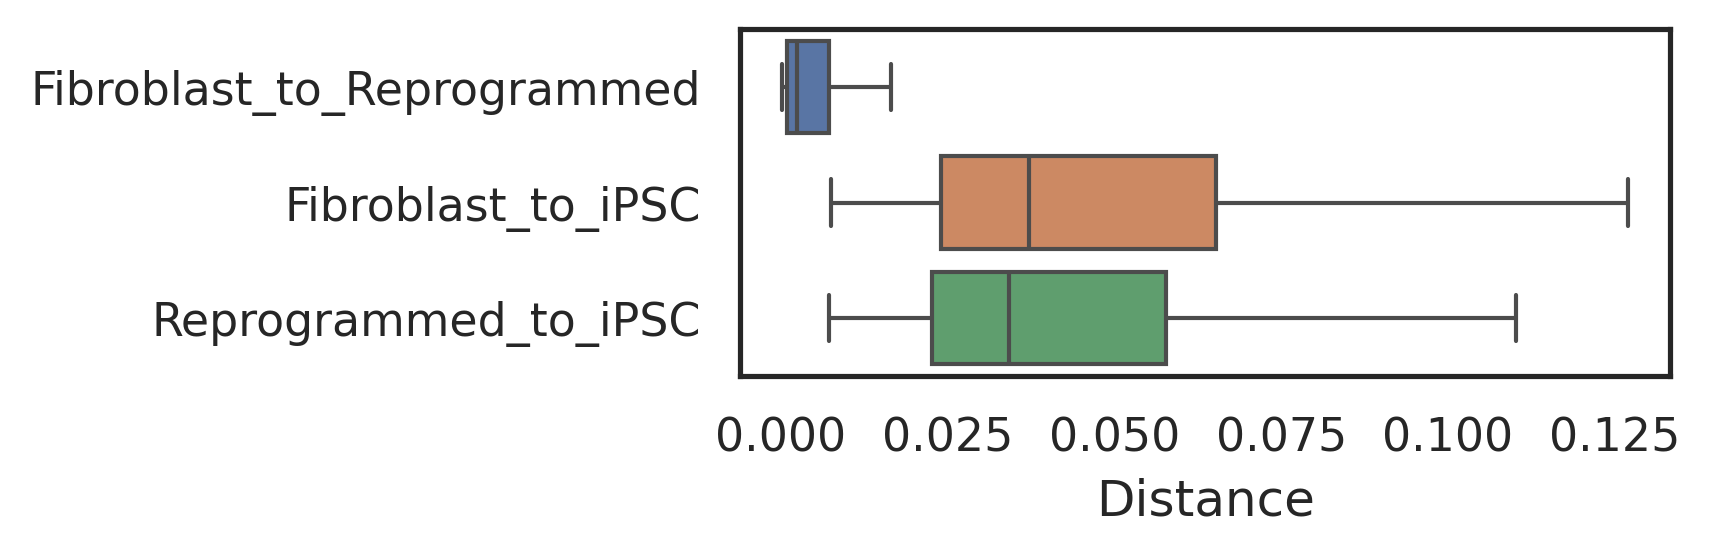

In [77]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.5

sns.boxplot(data=result[result['towards_ipsc']].drop(columns='towards_ipsc').melt(id_vars='gene_name'),
            x='value',
            y='variable',
            hue='variable',
            showfliers=False,
            )

plt.ylabel('')
plt.xlabel('Distance')

In [ ]:
plot_df = result.melt(id_vars='gene_name')
plot_df.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 7
sns.scatterplot(data=plot_df.sample(30),
                 x='value',
                 y='gene_name',
                 hue='variable',
                 zorder=4,
                 ec='k',
               )

plt.grid(axis='y', zorder=1)

sns.move_legend(plt.gca(),
                title='Cosine Distance',
                loc='upper right',
                bbox_to_anchor=(2.1, 1),
                )

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [484999, 141349, 463041, 393705, 549608]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

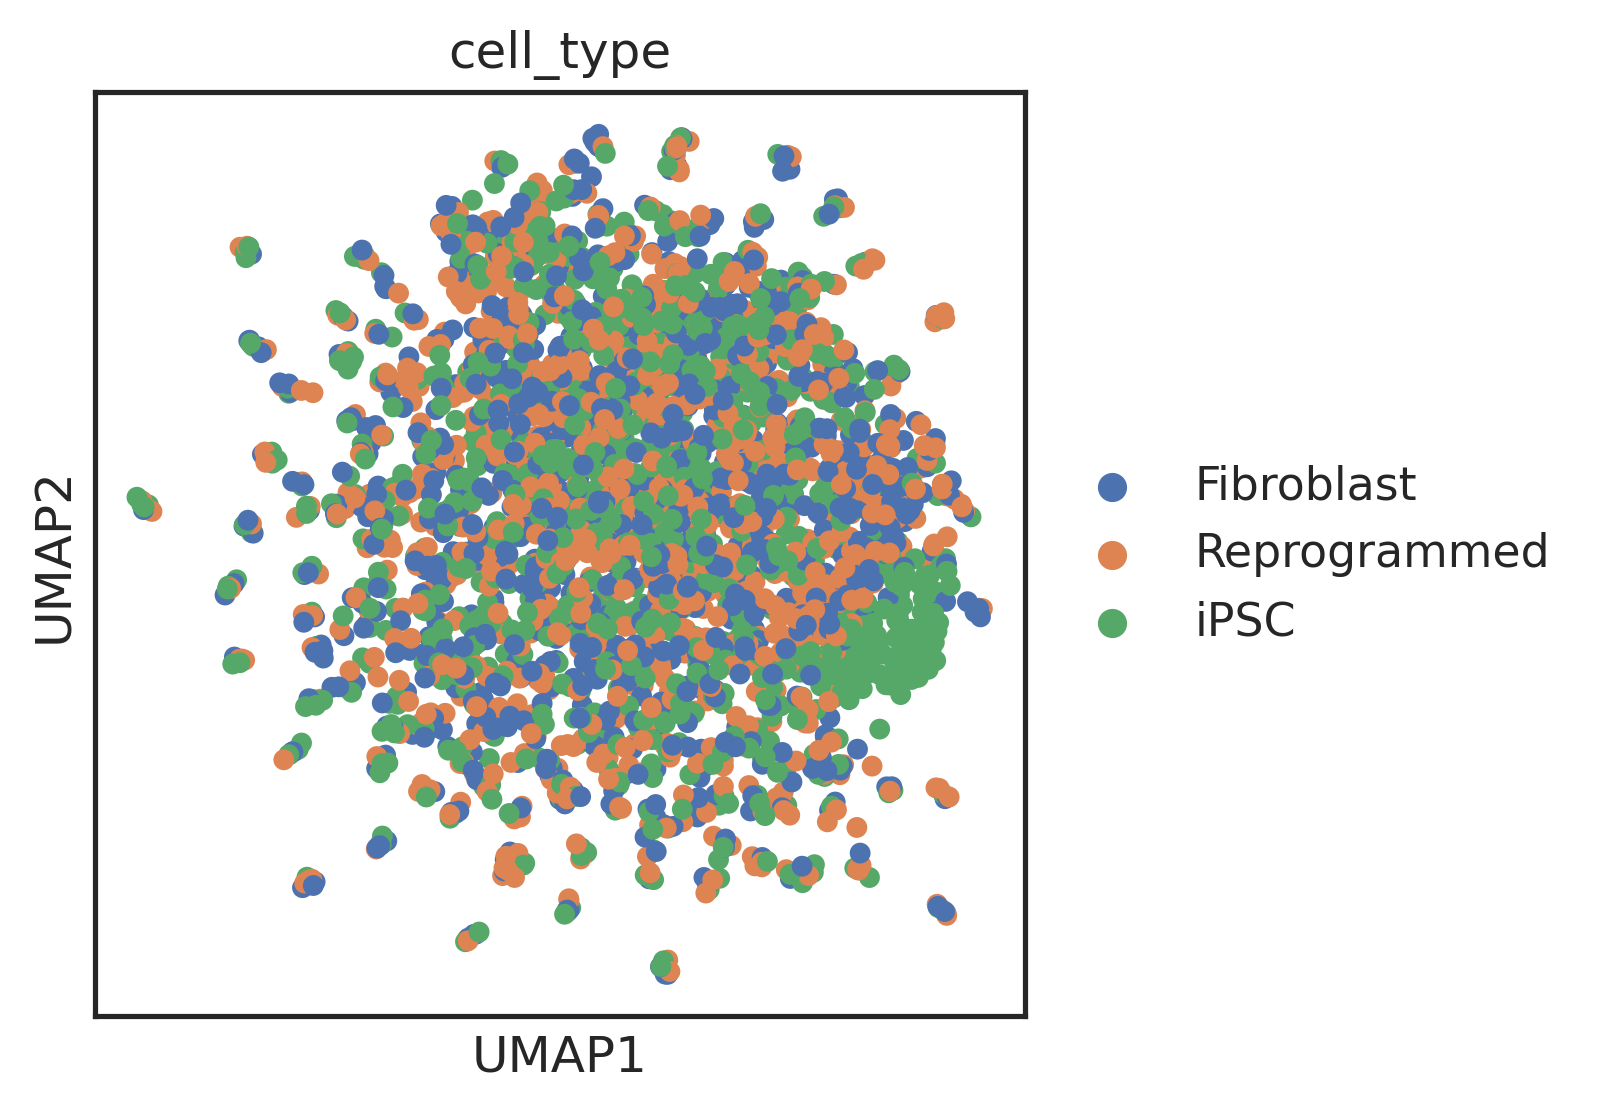

AnnData object with n_obs × n_vars = 3110 × 512
    obs: 'token_id', 'cell_id', 'time_point', 'cell_type', 'gene_id', 'gene_name', 'nonzero_median', 'gene_version', 'gene_biotype', 'Chromosome', 'Start', 'End', 'scenic_tf'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
adata = an.AnnData(pdf[features].to_numpy())
adata.obs = pdf[metadata_columns]

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=['cell_type'],
    ncols=1,
    size=100,
    color_map='tab20',
)

adata

In [ ]:
for gene, group in pdf.groupby('gene_name'):
    
    group = group.sort_values(by='cell_type')
    print(gene, group.shape)
    break

In [ ]:
group.head()

In [ ]:
pdf.head()